# Technical Analysis - Basic Models

#### Model 1 - Mean variable feature
#### Model 2 - Linear trending (regression)
#### Model 3 - Random Walk model
#### Model 4 - Moving average smoothing sequencing feature
#### Model 5 - Exponential Smoothing sequencing feature
#### Model 6 - Improve on Linear trending by adding AUDUSD base currency as another regressor feature
#### Model 7 - Improve on Linear trending by adding OPEC Oil Price as another regressor feature
#### Model 8 - Improve on Linear trending by adding bothe AUDUSD and OPEC Oil Price as multiple regressor features

# Visualise the TS

In [1]:
# set up the environment for the data exploration
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# Import statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

In [3]:
# Set some parameters to get good visuals - style to ggplot and size to 15,10
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)

In [4]:
# for a start, there is a need to change 'Date' from data type 'object' to TS object
dateparse = lambda dates: pd.datetime.strptime(dates, '%d-%b-%y')

In [5]:
# followed by a ts parse of the same original CVS data, index datetime column
data1 = pd.read_csv('aud_fx_thb_jpy_usd.csv', na_values=[' '], parse_dates=[0], index_col=[0], date_parser=dateparse)
# drop the null values
data2= pd.DataFrame(data1.AUDTHB).dropna()
print (data2.head())

            AUDTHB
Date              
2006-01-02  30.080
2006-01-03  30.160
2006-01-04  30.195
2006-01-05  30.050
2006-01-06  29.990


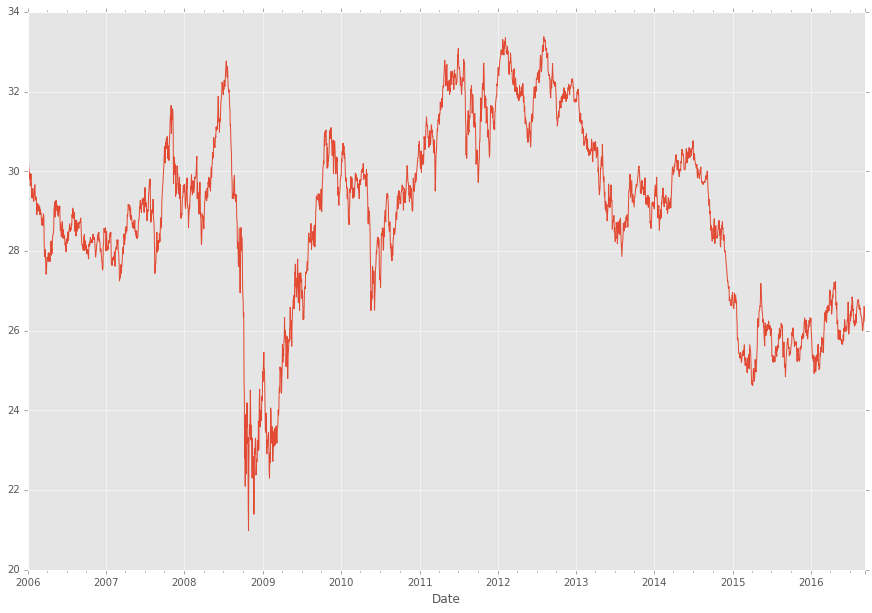

In [6]:
data2.AUDTHB.plot()

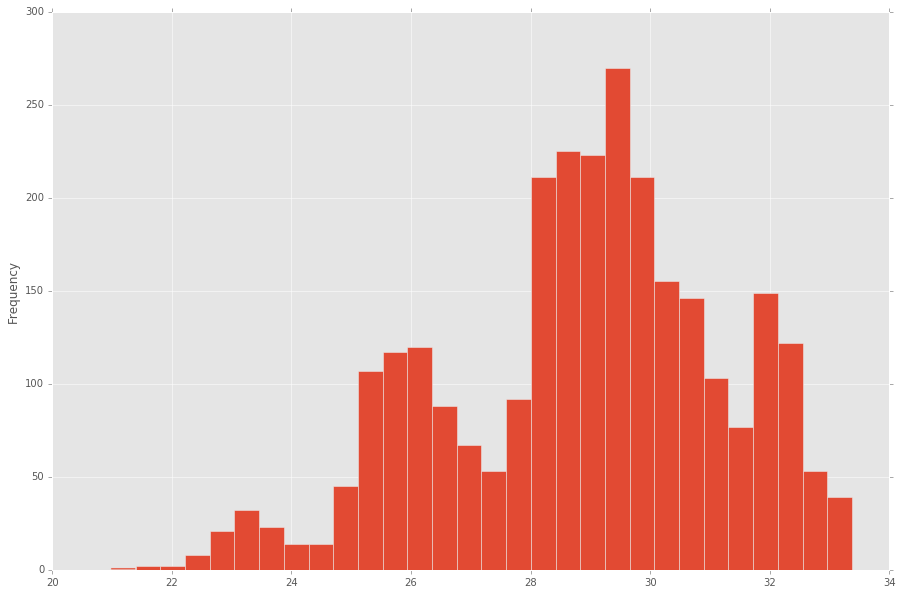

In [7]:
data2.AUDTHB.plot(kind = "hist", bins = 30)

In [8]:
# a log transformation usually make things more normal distribution... as in closer fitting the central limit theorem.
data2['AUDTHB_log'] = np.log(data2.AUDTHB)
data2.head()

,AUDTHB,AUDTHB_log
Date,,
2006-01-02,30.080,3.403860
2006-01-03,30.160,3.406517
2006-01-04,30.195,3.407676
2006-01-05,30.050,3.402863
2006-01-06,29.990,3.400864


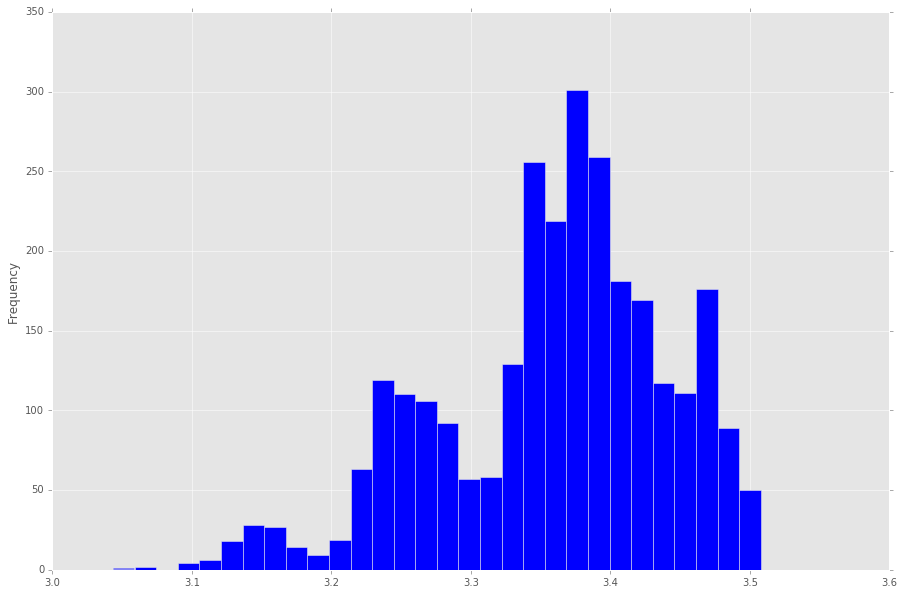

In [9]:
data2.AUDTHB_log.plot(kind = "hist", color='b', bins = 30)

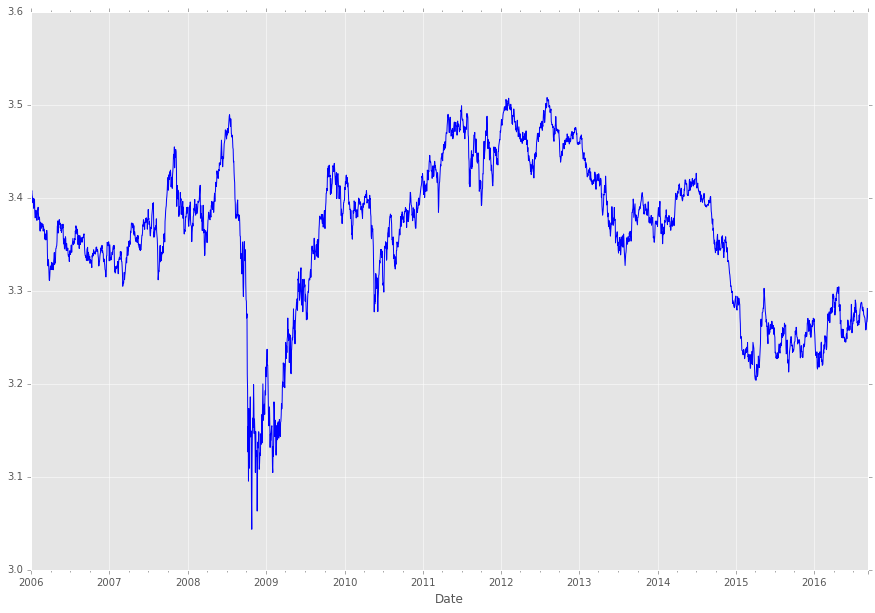

In [10]:
data2.AUDTHB_log.plot(kind = "line", color='b')

# Model 1 - mean variable

In [11]:
model_mean_pred = data2.AUDTHB_log.mean()

In [12]:
# Store this as a Mean Predication Value
# Let us store this as our Mean Predication Value
data2["AUDTHB_mean"] = np.exp(model_mean_pred)
data2.head()

,AUDTHB,AUDTHB_log,AUDTHB_mean
Date,,,
2006-01-02,30.080,3.403860,28.763824
2006-01-03,30.160,3.406517,28.763824
2006-01-04,30.195,3.407676,28.763824
2006-01-05,30.050,3.402863,28.763824
2006-01-06,29.990,3.400864,28.763824


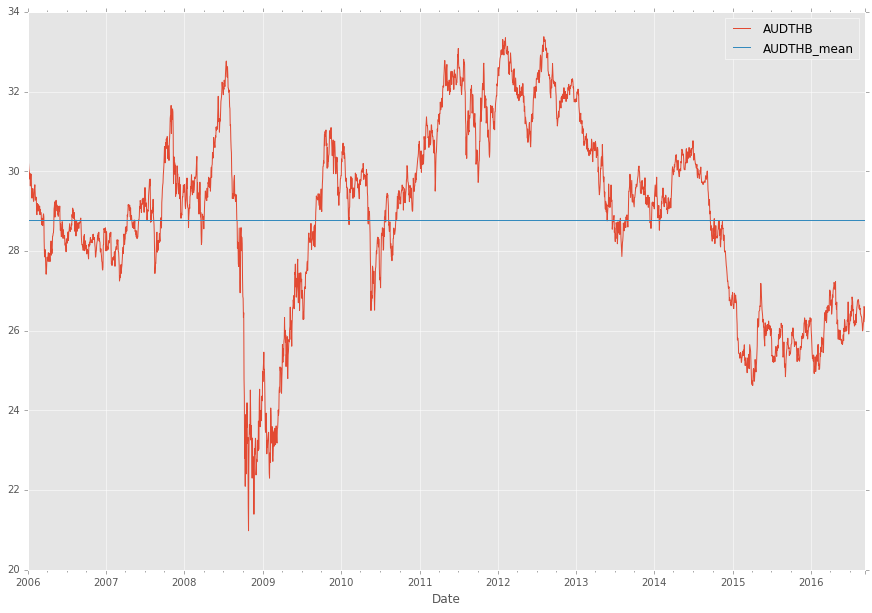

In [13]:
data2.plot(kind="line", y = ["AUDTHB", "AUDTHB_mean"])

In [14]:
# use Root Mean Squared Error (RMSE) to calculate our error values of this model.
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [15]:
model_mean_RMSE = RMSE(data2.AUDTHB_mean, data2.AUDTHB)
model_mean_RMSE

2.3362121765652843

In [16]:
# Save this in a new dataframe as model comparison table
modResults = pd.DataFrame(columns = ["Model", "Forecast", "RMSE"])
modResults.head()

,Model,Forecast,RMSE


In [17]:
# populate df with mean model results
modResults.loc[0,"Model"] = "Mean"
modResults.loc[0,"Forecast"] = np.exp(model_mean_pred)
modResults.loc[0,"RMSE"] = model_mean_RMSE
modResults.head()

,Model,Forecast,RMSE
0,Mean,28.7638,2.33621


RMSE can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable. Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and is the most important criterion for fit if the main purpose of the model is prediction.

# Model 2 - linear trend

In [18]:
data2.index.min()

Timestamp('2006-01-02 00:00:00')

In [19]:
data2["timeIndex"] = data2.index - data2.index.min()
print (data2.head())

            AUDTHB  AUDTHB_log  AUDTHB_mean  timeIndex
Date                                                  
2006-01-02  30.080    3.403860    28.763824     0 days
2006-01-03  30.160    3.406517    28.763824     1 days
2006-01-04  30.195    3.407676    28.763824     2 days
2006-01-05  30.050    3.402863    28.763824     3 days
2006-01-06  29.990    3.400864    28.763824     4 days


In [20]:
data2.dtypes

AUDTHB                 float64
AUDTHB_log             float64
AUDTHB_mean            float64
timeIndex      timedelta64[ns]
dtype: object

In [21]:
# Convert to days using the timedelta function
data2["timeIndex"] =  data2["timeIndex"]/np.timedelta64(1, 'D')

In [22]:
data2.timeIndex.head()

Date
2006-01-02    0.0
2006-01-03    1.0
2006-01-04    2.0
2006-01-05    3.0
2006-01-06    4.0
Name: timeIndex, dtype: float64

In [23]:
# Round the number to 0
data2["timeIndex"] = data2["timeIndex"].round(0).astype(int)

In [24]:
data2.timeIndex.tail()

Date
2016-09-05    3899
2016-09-06    3900
2016-09-07    3901
2016-09-08    3902
2016-09-09    3903
Name: timeIndex, dtype: int32

In [25]:
# drop nulls
data2=data2[data2.AUDTHB > 0]
np.round(data2.describe(), 2)

,AUDTHB,AUDTHB_log,AUDTHB_mean,timeIndex
count,2790.00,2790.00,2790.00,2790.00
mean,28.86,3.36,28.76,1951.50
std,2.33,0.08,0.00,1127.77
min,20.98,3.04,28.76,0.00
25%,27.47,3.31,28.76,975.25
50%,29.14,3.37,28.76,1951.50
75%,30.45,3.42,28.76,2927.75
max,33.38,3.51,28.76,3903.00


In [26]:
# plotting a linear trend (regression) model between AUDTHB_log and Date.
model_linear = smf.ols('AUDTHB_log ~ timeIndex', data = data2).fit()

In [27]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             AUDTHB_log   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     48.53
Date:                Wed, 28 Sep 2016   Prob (F-statistic):           4.04e-12
Time:                        18:06:50   Log-Likelihood:                 3010.0
No. Observations:                2790   AIC:                            -6016.
Df Residuals:                    2788   BIC:                            -6004.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3779      0.003   1084.657      0.000       3.372       3.384
timeIndex  -9.626e-06   1.38e-06     -6.966      0.000   -1.23e-05   -6.92e-06
==============================================================================
Omnibus:                      162.476   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.037
Skew:                          -0.614   Prob(JB):                     3.29e-42
Kurtosis:                       3.370   Cond. No.                     4.51e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
## Parameters for y = mx + c equation
model_linear.params

Intercept    3.377904
timeIndex   -0.000010
dtype: float64

In [29]:
# intercept value is
c = model_linear.params[0]
c

3.3779036830034759

In [30]:
# gradient value is
m = model_linear.params[1]
m

-9.6260224351539618e-06

In [31]:
model_linear_pred = model_linear.predict()

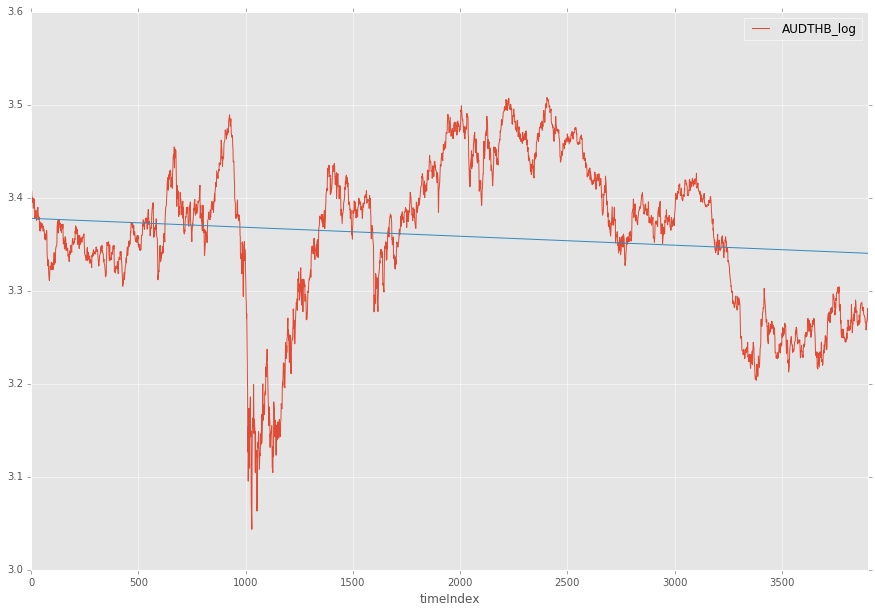

In [32]:
# Plot the prediction line
data2.plot(kind="line", x="timeIndex", y = "AUDTHB_log")
plt.plot(data2.timeIndex,model_linear_pred, '-')

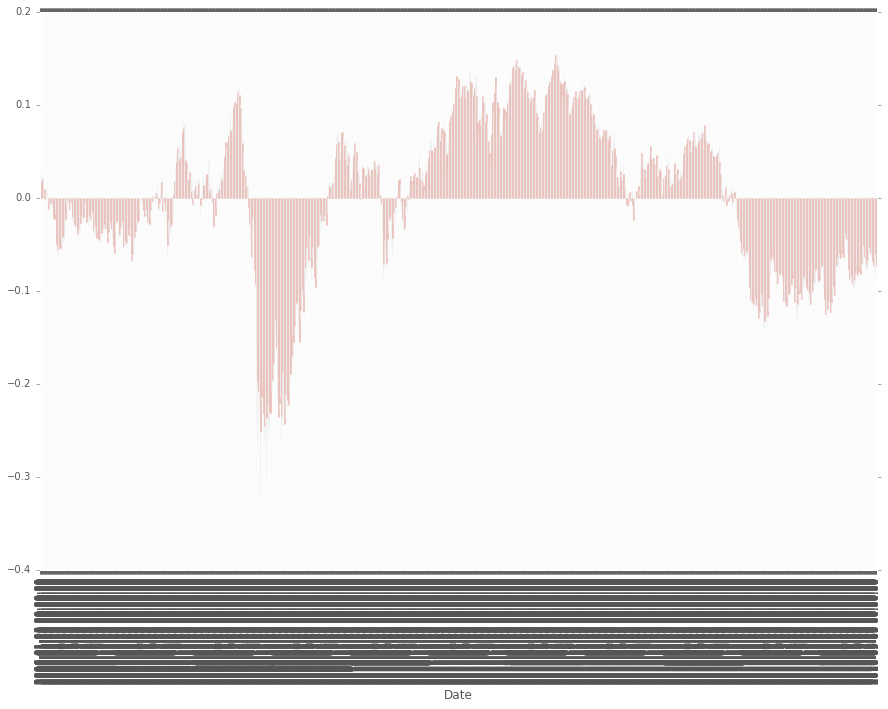

In [33]:
model_linear.resid.plot(kind = "bar")

If the model has succeeded in extracting all the "signal" from the data, there should be no pattern at all in the errors: the error in the next period should not be correlated with any previous errors. The linear trend model obviously fails the autocorrelation test in this case.

In [43]:
# Test with manual calculation for last date
model_linear_forecast_manual = m * 2790 + c
model_linear_forecast_manual

3.3510470804093964

In [44]:
# Using Predict Function to validate the manual calc in previous step
model_linear_forecast_auto = model_linear.predict(exog = dict(timeIndex=2790))
model_linear_forecast_auto

array([ 3.35104708])

In [45]:
# transpose log back to original values
data2["AUDTHB_linear"] = np.exp(model_linear_pred)
data2.head()

,AUDTHB,AUDTHB_log,AUDTHB_mean,timeIndex,AUDTHB_linear
Date,,,,,
2006-01-02,30.080,3.403860,28.763824,0,29.309265
2006-01-03,30.160,3.406517,28.763824,1,29.308983
2006-01-04,30.195,3.407676,28.763824,2,29.308701
2006-01-05,30.050,3.402863,28.763824,3,29.308419
2006-01-06,29.990,3.400864,28.763824,4,29.308137


In [46]:
# what is the Root Mean Squared Error (RMSE)?
model_linear_RMSE = RMSE(data2.AUDTHB_linear, data2.AUDTHB)
model_linear_RMSE

2.3184220883698785

In [47]:
# put results in the comparison table
modResults.loc[1,"Model"] = "Linear"
modResults.loc[1,"Forecast"] = np.exp(model_linear_forecast_manual)
modResults.loc[1,"RMSE"] = model_linear_RMSE
modResults.head()

,Model,Forecast,RMSE
0,Mean,28.7638,2.33621
1,Linear,28.5326,2.31842


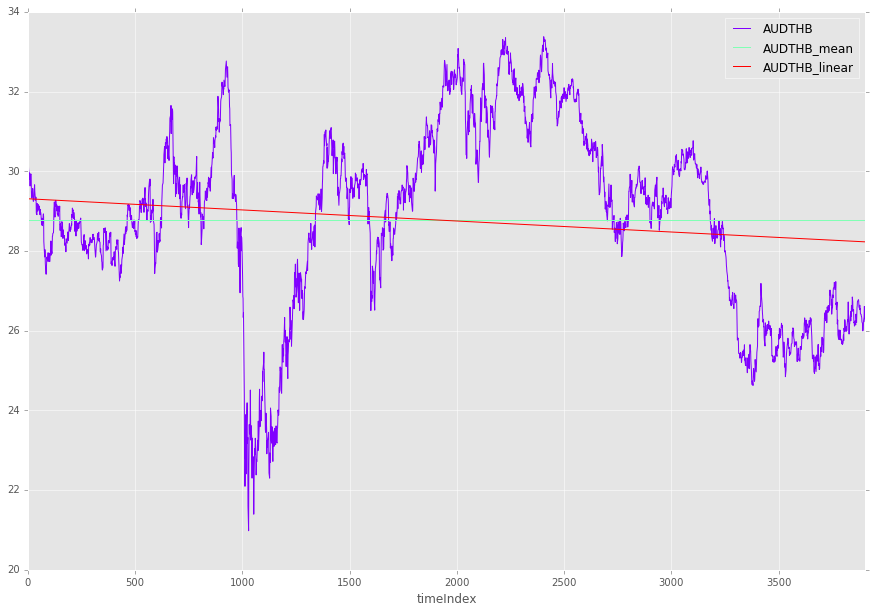

In [48]:
# what does the plot look like for this model?
data2.plot(kind="line", x="timeIndex", colormap='rainbow', y = ["AUDTHB", "AUDTHB_mean", "AUDTHB_linear"])

# 3. Random Walk Model

In [49]:
# A bit of data wrangling needed here - log transform, merge by date, drop nulls, etc..

In [50]:
# create the randomw walk shift = 5 days feature
# assuming here that 5 days is a good forex trading lag time for market to respond to changes
# also regional trading block works on 5 days trading.
data2["AUDTHB_logShift1"] = data2.AUDTHB_log.shift(5)
data2.head()

,AUDTHB,AUDTHB_log,AUDTHB_mean,timeIndex,AUDTHB_linear,AUDTHB_logShift1
Date,,,,,,
2006-01-02,30.080,3.403860,28.763824,0,29.309265,NaN
2006-01-03,30.160,3.406517,28.763824,1,29.308983,NaN
2006-01-04,30.195,3.407676,28.763824,2,29.308701,NaN
2006-01-05,30.050,3.402863,28.763824,3,29.308419,NaN
2006-01-06,29.990,3.400864,28.763824,4,29.308137,NaN


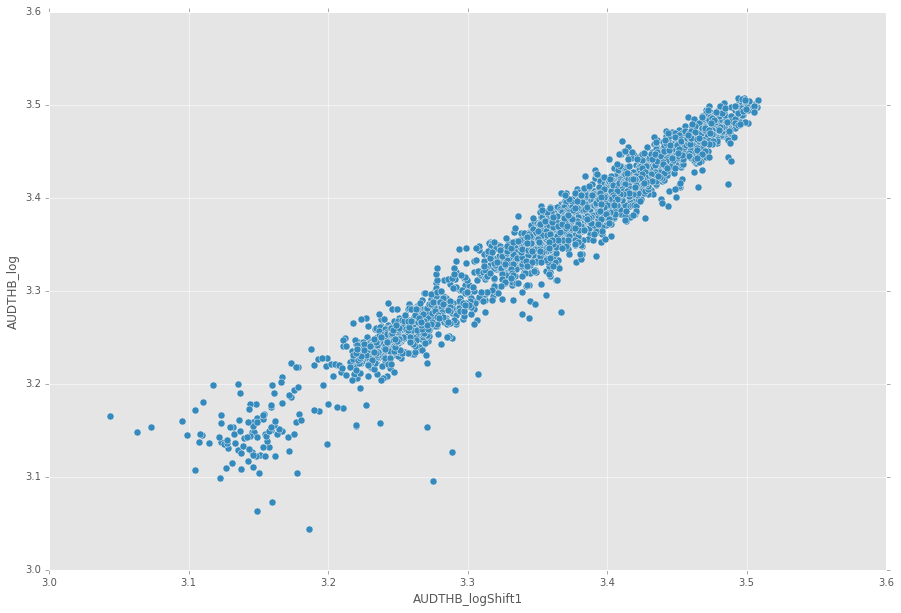

In [51]:
# I want to visualise and check the shift
data2.plot(kind= "scatter", y = "AUDTHB_log", x = "AUDTHB_logShift1", s = 50)

In [52]:
# plot the 5-days difference curve
data2["AUDTHB_logDiff1"] = data2.AUDTHB_log - data2.AUDTHB_logShift1

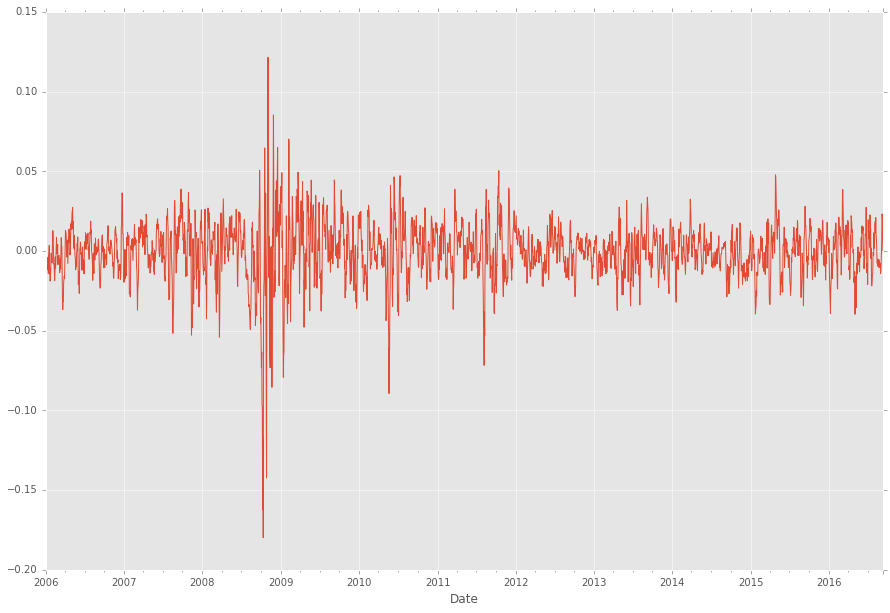

In [53]:
data2.AUDTHB_logDiff1.plot()

In [54]:
# convert log back to original
data2["AUDTHB_random1"] = np.exp(data2.AUDTHB_logShift1)
data2.head()

,AUDTHB,AUDTHB_log,AUDTHB_mean,timeIndex,AUDTHB_linear,AUDTHB_logShift1,AUDTHB_logDiff1,AUDTHB_random1
Date,,,,,,,,
2006-01-02,30.080,3.403860,28.763824,0,29.309265,NaN,NaN,NaN
2006-01-03,30.160,3.406517,28.763824,1,29.308983,NaN,NaN,NaN
2006-01-04,30.195,3.407676,28.763824,2,29.308701,NaN,NaN,NaN
2006-01-05,30.050,3.402863,28.763824,3,29.308419,NaN,NaN,NaN
2006-01-06,29.990,3.400864,28.763824,4,29.308137,NaN,NaN,NaN


In [55]:
data2.tail()

,AUDTHB,AUDTHB_log,AUDTHB_mean,timeIndex,AUDTHB_linear,AUDTHB_logShift1,AUDTHB_logDiff1,AUDTHB_random1
Date,,,,,,,,
2016-09-05,26.3400,3.271089,28.763824,3899,28.229621,3.264805,0.006284,26.175
2016-09-06,26.6050,3.281099,28.763824,3900,28.229349,3.257904,0.023195,25.995
2016-09-07,26.5800,3.280159,28.763824,3901,28.229078,3.259058,0.021101,26.025
2016-09-08,26.5800,3.280159,28.763824,3902,28.228806,3.263084,0.017075,26.130
2016-09-09,26.2265,3.266770,28.763824,3903,28.228534,3.266713,0.000057,26.225


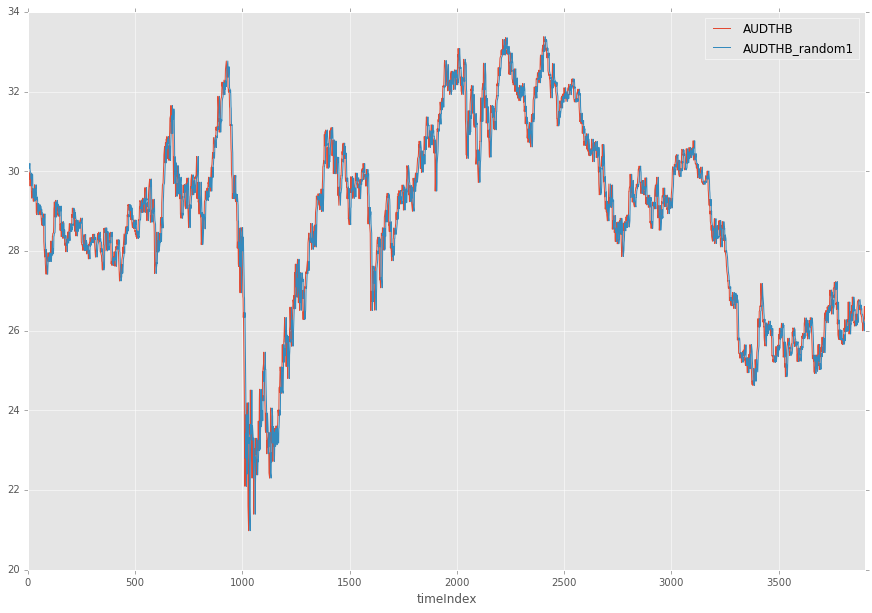

In [56]:
# now I'll plot the random walk model
data2.plot(kind="line", x="timeIndex", y = ["AUDTHB","AUDTHB_random1"])

In [57]:
# Root Mean Squared Error (RMSE)
model_random_RMSE = RMSE(data2.AUDTHB_random1,data2.AUDTHB)
model_random_RMSE

0.48484164149230802

In [60]:
# put results in the comparison table
modResults.loc[2,"Model"] = "Random"
modResults.loc[2,"Forecast"] = np.exp(data2.AUDTHB_logShift1[-1])
modResults.loc[2,"RMSE"] = model_random_RMSE
modResults.head()

,Model,Forecast,RMSE
0,Mean,28.7638,2.33621
1,Linear,28.5326,2.31842
2,Random,26.225,0.484842


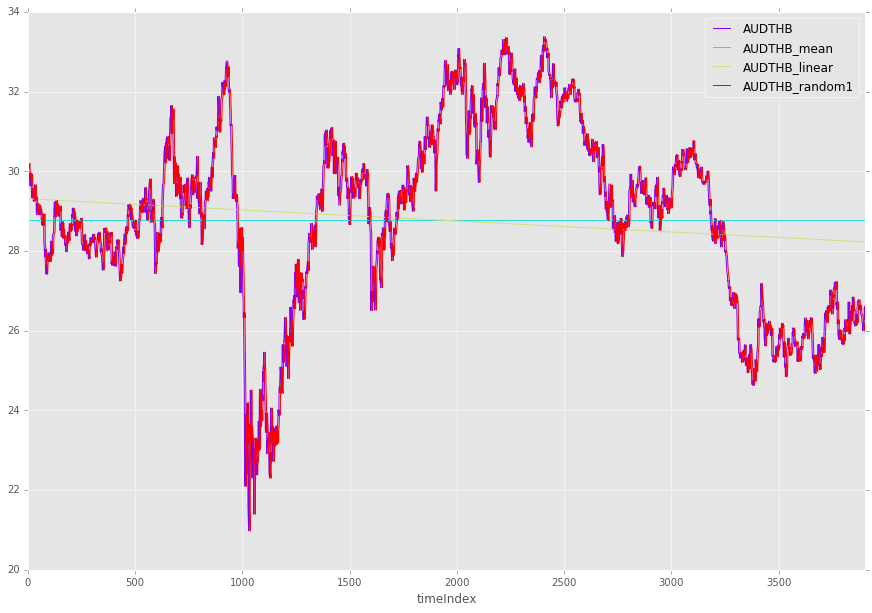

In [61]:
# include this model into comparison plot
data2.plot(kind="line", x="timeIndex", colormap='rainbow',
           y = ["AUDTHB", "AUDTHB_mean", "AUDTHB_linear", "AUDTHB_random1"])

# 4. Moving Average / Smoothing model

In [62]:
# as I have daily data for > 10 years, a montly (30-days) moving average is reasonably assumed.
#data2['AUDTHB_log30days'] = pd.rolling_mean(data2.AUDTHB_log, window = 30)

In [63]:
# as I have daily data for > 10 years, a montly (30-days) moving average is reasonably assumed.
data2['AUDTHB_log30days'] = pd.Series.rolling(data2.AUDTHB_log, window = 30, center=False).mean()

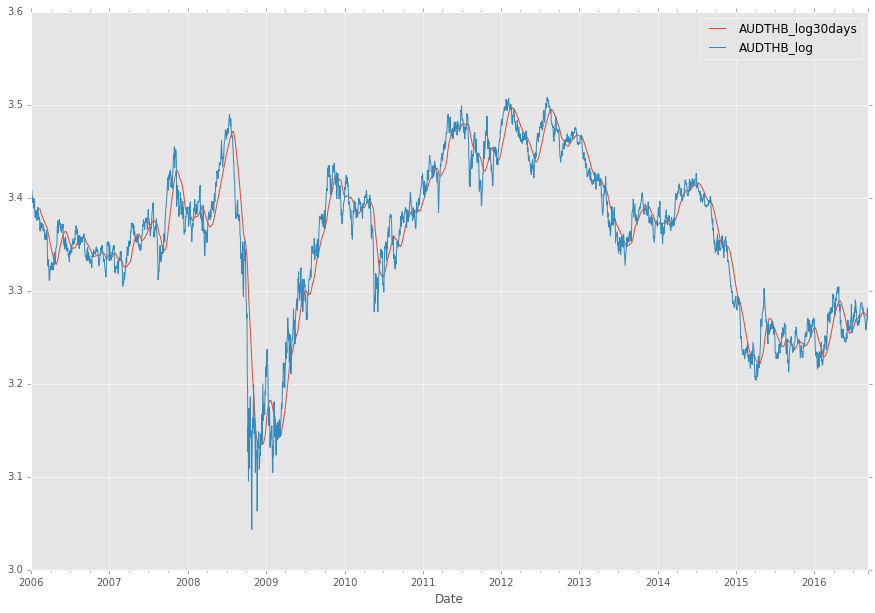

In [64]:
# visualise
data2.plot(kind ="line", y=["AUDTHB_log30days", "AUDTHB_log"])

In [78]:
# difference from random walk model - the moving avg is weighted over previous 30 days.

In [65]:
# create the predicted variable 
data2["AUDTHB_30days"] = np.exp(data2.AUDTHB_log30days)
data2.tail()

,AUDTHB,AUDTHB_log,AUDTHB_mean,timeIndex,AUDTHB_linear,AUDTHB_logShift1,AUDTHB_logDiff1,AUDTHB_random1,AUDTHB_log30days,AUDTHB_30days
Date,,,,,,,,,,
2016-09-05,26.3400,3.271089,28.763824,3899,28.229621,3.264805,0.006284,26.175,3.273933,26.415021
2016-09-06,26.6050,3.281099,28.763824,3900,28.229349,3.257904,0.023195,25.995,3.274374,26.426684
2016-09-07,26.5800,3.280159,28.763824,3901,28.229078,3.259058,0.021101,26.025,3.274892,26.440381
2016-09-08,26.5800,3.280159,28.763824,3902,28.228806,3.263084,0.017075,26.130,3.275442,26.454928
2016-09-09,26.2265,3.266770,28.763824,3903,28.228534,3.266713,0.000057,26.225,3.275204,26.448614


In [66]:
model_30days_forecast = data2.AUDTHB_log.tail(30).mean()

In [67]:
# Root Mean Squared Error (RMSE)
model_MA12_RMSE = RMSE(data2.AUDTHB_30days,data2.AUDTHB)
model_MA12_RMSE

0.64010041390016637

In [68]:
modResults.loc[3,"Model"] = "MovAvg30"
modResults.loc[3,"Forecast"] = np.exp(model_30days_forecast)
modResults.loc[3,"RMSE"] = model_MA12_RMSE
modResults.head()

,Model,Forecast,RMSE
0,Mean,28.7638,2.33621
1,Linear,28.5326,2.31842
2,Random,26.225,0.484842
3,MovAvg30,26.4486,0.6401


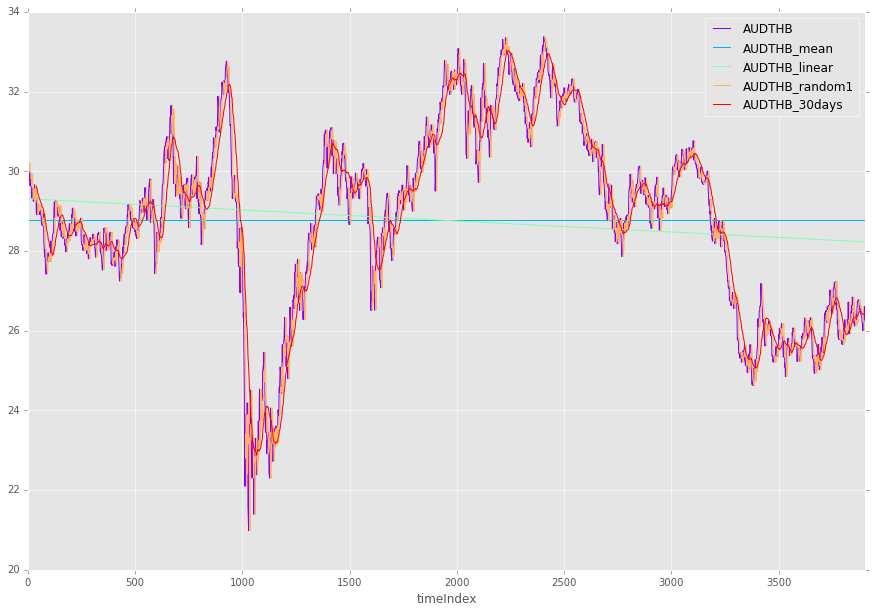

In [69]:
# include this model into comparison plot
data2.plot(kind="line", colormap='rainbow', x="timeIndex", 
           y = ["AUDTHB", "AUDTHB_mean", "AUDTHB_linear", "AUDTHB_random1", "AUDTHB_30days"])

# 5. Exponential Smoothing Model 

In [70]:
# works by giving more weight to the recent observations and less to the older ones. 
# This is done by the using a smoothing variable like alpha

In [71]:
# create the var
#data2['AUDTHB_logES30'] = pd.ewma(data2.AUDTHB_log, halflife=30)

In [72]:
# create the var
data2['AUDTHB_logES30'] = pd.Series.ewm(data2.AUDTHB_log,adjust=True,min_periods=0,halflife=30,ignore_na=False).mean()

In [73]:
# get alpha value, assume halflife = 30 days, to be consistent with previous model
halflife = 30
alpha = 1 - np.exp(np.log(0.5)/halflife)
alpha

0.022840031565754093

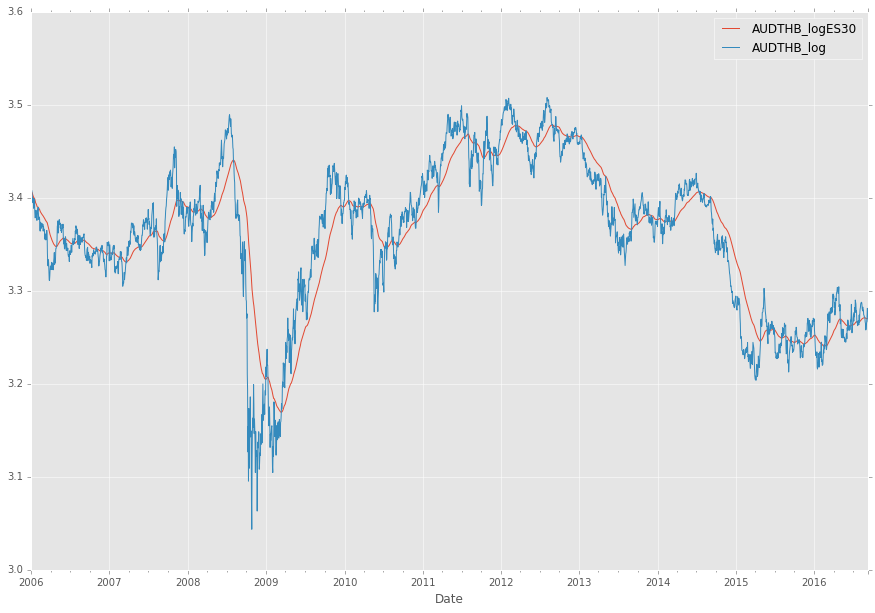

In [74]:
#visualise to see if it's all good
data2.plot(kind ="line", y=["AUDTHB_logES30", "AUDTHB_log"])

In [89]:
# the smoothing looks better

In [75]:
# create the predicted variable 
data2["AUDTHB_ES30"] = np.exp(data2.AUDTHB_logES30)
data2.tail()

,AUDTHB,AUDTHB_log,AUDTHB_mean,timeIndex,AUDTHB_linear,AUDTHB_logShift1,AUDTHB_logDiff1,AUDTHB_random1,AUDTHB_log30days,AUDTHB_30days,AUDTHB_logES30,AUDTHB_ES30
Date,,,,,,,,,,,,
2016-09-05,26.3400,3.271089,28.763824,3899,28.229621,3.264805,0.006284,26.175,3.273933,26.415021,3.269965,26.310425
2016-09-06,26.6050,3.281099,28.763824,3900,28.229349,3.257904,0.023195,25.995,3.274374,26.426684,3.270220,26.317116
2016-09-07,26.5800,3.280159,28.763824,3901,28.229078,3.259058,0.021101,26.025,3.274892,26.440381,3.270447,26.323091
2016-09-08,26.5800,3.280159,28.763824,3902,28.228806,3.263084,0.017075,26.130,3.275442,26.454928,3.270668,26.328931
2016-09-09,26.2265,3.266770,28.763824,3903,28.228534,3.266713,0.000057,26.225,3.275204,26.448614,3.270579,26.326587


In [76]:
# Root Mean Squared Error (RMSE)
model_ES30_RMSE = RMSE(data2.AUDTHB_ES30, data2.AUDTHB)
model_ES30_RMSE

0.93904543805629459

In [77]:
# get parameters for ES model
y_exp = data2.AUDTHB_log[-1]
y_exp

3.2667703499774472

In [78]:
# get parameters for ES model
y_for = data2.AUDTHB_logES30[-1]
y_for

3.2705793556237661

In [79]:
# run the modelling algorithm
model_ES30_forecast = alpha * y_exp + (1 - alpha) * y_for

In [80]:
# table the results
modResults.loc[4,"Model"] = "ExpSmoothing30"
modResults.loc[4,"Forecast"] = np.exp(model_ES30_forecast)
modResults.loc[4,"RMSE"] = model_ES30_RMSE
modResults.head()

,Model,Forecast,RMSE
0,Mean,28.7638,2.33621
1,Linear,28.5326,2.31842
2,Random,26.225,0.484842
3,MovAvg30,26.4486,0.6401
4,ExpSmoothing30,26.3243,0.939045


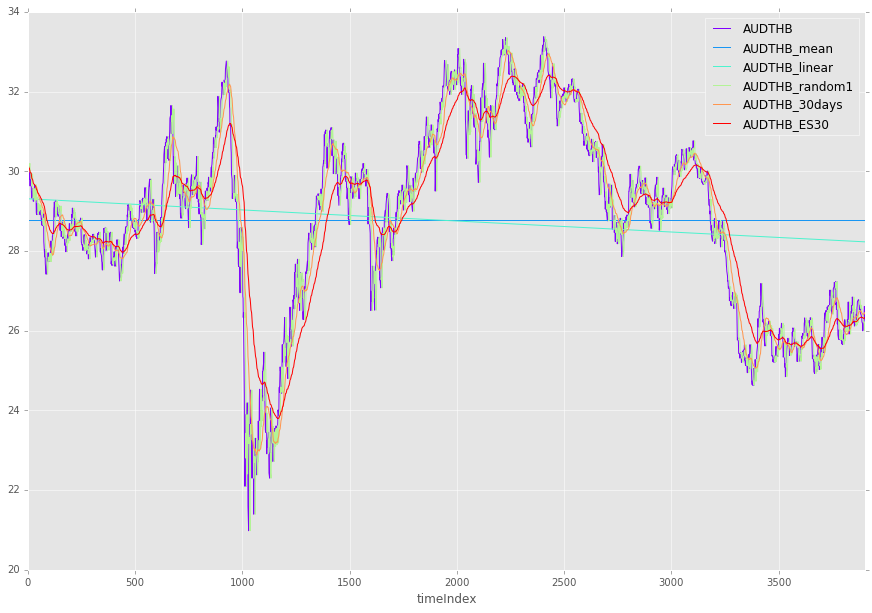

In [81]:
# include this model into comparison plot
data2.plot(kind="line", colormap='rainbow', x="timeIndex", 
           y = ["AUDTHB", "AUDTHB_mean", "AUDTHB_linear", "AUDTHB_random1", "AUDTHB_30days", "AUDTHB_ES30"])

# 6. Improve on Linear Model (#2) with AUDUSD as additional regressor

In [82]:
# Previous fundamental analysis shows a strong correlation with AUDUSD currency pair.
# This feature will be used to enrich the linear model.

In [83]:
# Start with a bit of data wrangling - merge the AUDUSD data, time-index, drop nulls, etc.

In [84]:
# ts parse of the same original CVS data, index datetime column
data3 = pd.read_csv('aud_fx_thb_jpy_usd.csv', na_values=[' '], parse_dates=[0], index_col=[0], date_parser=dateparse)
# drop the null values
data3= pd.DataFrame(data3.AUDUSD).dropna()
print (data3.head())

            AUDUSD
Date              
2006-01-02  0.7331
2006-01-03  0.7398
2006-01-04  0.7478
2006-01-05  0.7475
2006-01-06  0.7541


In [85]:
data3.dtypes

AUDUSD    float64
dtype: object

In [86]:
data3.index.min()

Timestamp('2006-01-02 00:00:00')

In [87]:
data3["timeIndex"] = data3.index - data3.index.min()
print (data3.head())

            AUDUSD  timeIndex
Date                         
2006-01-02  0.7331     0 days
2006-01-03  0.7398     1 days
2006-01-04  0.7478     2 days
2006-01-05  0.7475     3 days
2006-01-06  0.7541     4 days


In [88]:
data3.dtypes

AUDUSD               float64
timeIndex    timedelta64[ns]
dtype: object

In [89]:
# Convert to days using the timedelta function
data3["timeIndex"] =  data3["timeIndex"]/np.timedelta64(1, 'D')
data3.timeIndex.head()

Date
2006-01-02    0.0
2006-01-03    1.0
2006-01-04    2.0
2006-01-05    3.0
2006-01-06    4.0
Name: timeIndex, dtype: float64

In [90]:
# Round the number to 0
data3["timeIndex"] = data3["timeIndex"].round(0).astype(int)
data3.timeIndex.tail()

Date
2016-09-05    3899
2016-09-06    3900
2016-09-07    3901
2016-09-08    3902
2016-09-09    3903
Name: timeIndex, dtype: int32

In [91]:
# drop nulls
data3=data3[data3.AUDUSD > 0]
np.round(data3.describe(), 2)

,AUDUSD,timeIndex
count,2790.00,2790.00
mean,0.88,1951.50
std,0.12,1127.77
min,0.60,0.00
25%,0.77,975.25
50%,0.89,1951.50
75%,0.97,2927.75
max,1.10,3903.00


In [92]:
# okay... AUDUSD data looks good for a merge

In [93]:
# make a brand new DF after merge
data4 =data2.dropna().merge(data3.dropna(),on='timeIndex')
data4.head()

,AUDTHB,AUDTHB_log,AUDTHB_mean,timeIndex,AUDTHB_linear,AUDTHB_logShift1,AUDTHB_logDiff1,AUDTHB_random1,AUDTHB_log30days,AUDTHB_30days,AUDTHB_logES30,AUDTHB_ES30,AUDUSD
0,28.945,3.365397,28.763824,39,29.298264,3.384051,-0.018654,29.490,3.388255,29.614235,3.386425,29.560095,0.7373
1,28.910,3.364188,28.763824,42,29.297418,3.376734,-0.012546,29.275,3.386933,29.575098,3.385432,29.530753,0.7373
2,29.190,3.373826,28.763824,43,29.297136,3.377588,-0.003761,29.300,3.385843,29.542889,3.384925,29.515777,0.7420
3,29.025,3.368158,28.763824,44,29.296854,3.379293,-0.011135,29.350,3.384526,29.503998,3.384207,29.494596,0.7380
4,29.090,3.370394,28.763824,45,29.296572,3.377075,-0.006681,29.285,3.383443,29.472084,3.383627,29.477501,0.7389


In [109]:
#np.round(data4.describe(), 2)

In [94]:
## Now plot linear regression between AUDTHB and timeIndex, with AUDUSD as a regressor feature
# hold my breathe and model !
model_linear_USD = smf.ols('AUDTHB_log ~ timeIndex + np.log(AUDUSD)', data = data4).fit()

In [95]:
# what does the model look like?
model_linear_USD.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             AUDTHB_log   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                 1.013e+04
Date:                Wed, 28 Sep 2016   Prob (F-statistic):               0.00
Time:                        18:21:14   Log-Likelihood:                 5871.3
No. Observations:                2761   AIC:                        -1.174e+04
Df Residuals:                    2758   BIC:                        -1.172e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.4698      0.001   2682.047      0.000       3.467       3.472
timeIndex      -1.541e-05   4.94e-07    -31.182      0.000   -1.64e-05   -1.44e-05
np.log(AUDUSD)     0.5742      0.004    141.020      0.000       0.566       0.582
==============================================================================
Omnibus:                       90.724   Durbin-Watson:                   0.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.255
Skew:                          -0.448   Prob(JB):                     2.80e-22
Kurtosis:                       3.246   Cond. No.                     1.70e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [96]:
## What if I multiply the independent variables ?
# hold my breathe and model !
model_linear_USD2 = smf.ols('AUDTHB_log ~ timeIndex * np.log(AUDUSD)', data = data4).fit()

In [97]:
# what does the model look like?
model_linear_USD2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             AUDTHB_log   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     6785.
Date:                Wed, 28 Sep 2016   Prob (F-statistic):               0.00
Time:                        18:21:22   Log-Likelihood:                 5877.8
No. Observations:                2761   AIC:                        -1.175e+04
Df Residuals:                    2757   BIC:                        -1.172e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    3.4783      0.003   1290.276      0.000       3.473       3.484
timeIndex                -1.943e-05   1.22e-06    -15.903      0.000   -2.18e-05    -1.7e-05
np.log(AUDUSD)               0.6116      0.011     54.785      0.000       0.590       0.633
timeIndex:np.log(AUDUSD) -1.769e-05   4.92e-06     -3.597      0.000   -2.73e-05   -8.05e-06
==============================================================================
Omnibus:                       55.885   Durbin-Watson:                   0.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.822
Skew:                          -0.350   Prob(JB):                     1.69e-13
Kurtosis:                       3.151   Cond. No.                     4.78e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.78e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [114]:
# R2 value has not improved - there is no multiplicative effect of USD on AUDTHB !

In [98]:
# create a new var
data4["AUDTHB_linear_USD"] = np.exp(model_linear_USD.predict())

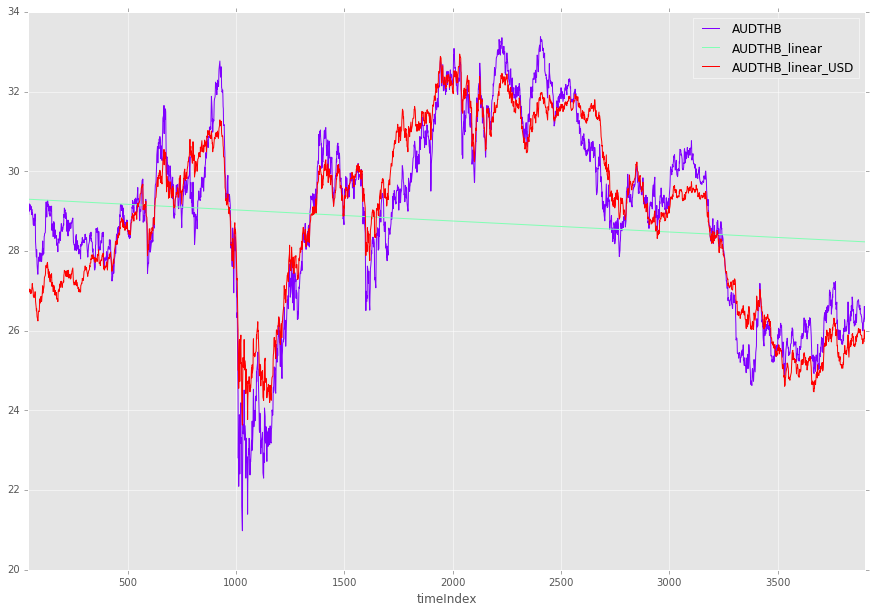

In [99]:
# see what the AUDTHB, Linear (AUDTHB only) and Linear (AUDTHB+AUDUSD) plots by looks like, side by side
data4.plot(kind="line", colormap='rainbow', x="timeIndex", 
           y = ["AUDTHB", "AUDTHB_linear", "AUDTHB_linear_USD"])

In [117]:
# wow! the AUDUSD regressor is a strong feature, and has vastly improved on the AUDTHB-only linear model.
# confirms the fundamental analysis done previously that AUDTHB trends strongly with AUDUSD, cos of AUD-USA ties,
# even though the AUD FX market is in the Asia trading block where the base currency is JPY.

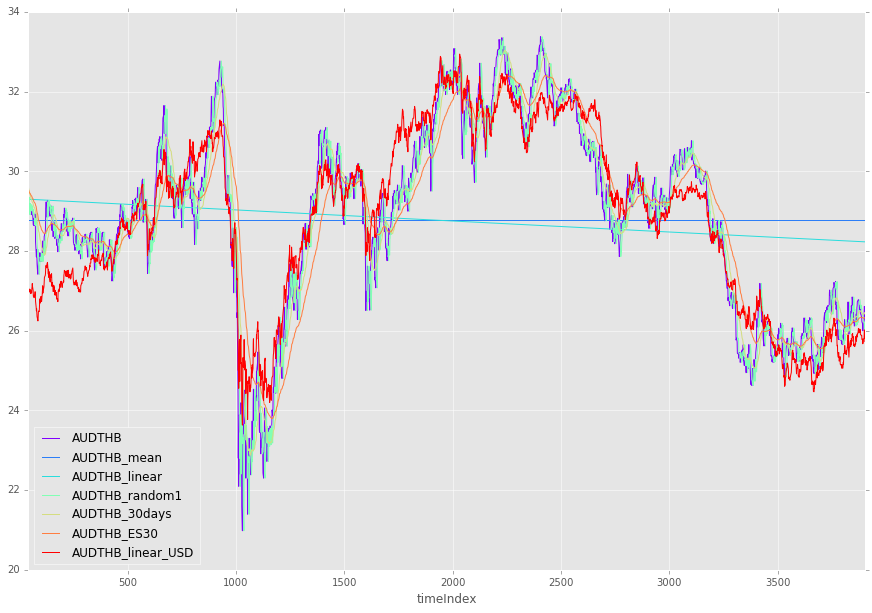

In [100]:
# include this the linear+AUDUSD model into comparison plot
data4.plot(kind="line", colormap='rainbow', x="timeIndex", 
           y = ["AUDTHB", "AUDTHB_mean", "AUDTHB_linear", "AUDTHB_random1", "AUDTHB_30days", "AUDTHB_ES30", "AUDTHB_linear_USD"])

In [101]:
# now to capture some RMSE comparison metrics
model_linearUSD_RMSE = RMSE(data4.AUDTHB_linear_USD, data4.AUDTHB)
model_linearUSD_RMSE

0.7994972118308209

In [102]:
# table the results
modResults.loc[5,"Model"] = "Linear_USD"
modResults.loc[5,"Forecast"] = data4.AUDTHB_linear_USD.iloc[-1]
modResults.loc[5,"RMSE"] = model_linearUSD_RMSE
modResults.head(10)

,Model,Forecast,RMSE
0,Mean,28.7638,2.33621
1,Linear,28.5326,2.31842
2,Random,26.225,0.484842
3,MovAvg30,26.4486,0.6401
4,ExpSmoothing30,26.3243,0.939045
5,Linear_USD,25.7282,0.799497


In [121]:
# the RMSE is pretty good. Even though the moving avg and exp smoothing methods also have good fits, 
# this linear method using AUDUSD regressor has better heuristic value, as it can be based on more tangible and
# real-life observation of AUDUSD trading to make a decision on AUDTHB buy/sell.

# 7. Even better linear model, adding Crude Oil as another feature?

In [122]:
# From previous fundamental analysis work, AUDTHB was shown to be tracking extremely well with OPEC crude oil prices.
# Perhaps adding this feature to the linear regression model will spike up a better fit?

In [123]:
# More data wrangling - read the CrudeOil data, time-index, drop nulls, merge etc.

In [103]:
# ts parse of Crude Oil data, index datetime column
data_oil = pd.read_csv('opec_orb.csv', na_values=[' '], parse_dates=[0], index_col=[0], date_parser=dateparse)
data_oil.head()

,Value
Date,
2006-01-02,56.20
2006-01-03,55.60
2006-01-04,56.38
2006-01-05,56.61
2006-01-06,56.78


In [104]:
# drop the null values
data_oil.columns = ['Oil_Price']
data_oil.head()

,Oil_Price
Date,
2006-01-02,56.20
2006-01-03,55.60
2006-01-04,56.38
2006-01-05,56.61
2006-01-06,56.78


In [105]:
data_oil.dtypes

Oil_Price    float64
dtype: object

In [106]:
data_oil.index.min()

Timestamp('2006-01-02 00:00:00')

In [107]:
data_oil["timeIndex"] = data_oil.index - data_oil.index.min()
print (data_oil.head())

            Oil_Price  timeIndex
Date                            
2006-01-02      56.20     0 days
2006-01-03      55.60     1 days
2006-01-04      56.38     2 days
2006-01-05      56.61     3 days
2006-01-06      56.78     4 days


In [108]:
data_oil.dtypes

Oil_Price            float64
timeIndex    timedelta64[ns]
dtype: object

In [109]:
# Convert to days using the timedelta function
data_oil["timeIndex"] =  data_oil["timeIndex"]/np.timedelta64(1, 'D')
data_oil.timeIndex.head()

Date
2006-01-02    0.0
2006-01-03    1.0
2006-01-04    2.0
2006-01-05    3.0
2006-01-06    4.0
Name: timeIndex, dtype: float64

In [110]:
# Round the number to 0
data_oil["timeIndex"] = data_oil["timeIndex"].round(0).astype(int)
data_oil.timeIndex.tail()

Date
2016-09-05    3899
2016-09-06    3900
2016-09-07    3901
2016-09-08    3902
2016-09-09    3903
Name: timeIndex, dtype: int32

In [111]:
# drop nulls and have a good look at the data stats
data_oil=data_oil[data_oil.Oil_Price > 0]
np.round(data_oil.describe(), 2)

,Oil_Price,timeIndex
count,2761.00,2761.00
mean,80.20,1952.27
std,26.21,1128.37
min,22.48,0.00
25%,58.10,975.00
50%,77.31,1953.00
75%,105.57,2930.00
max,140.73,3903.00


In [112]:
# make another brand new DF after merge
data5 =data4.dropna().merge(data_oil.dropna(),on='timeIndex')
data5.head()

,AUDTHB,AUDTHB_log,AUDTHB_mean,timeIndex,AUDTHB_linear,AUDTHB_logShift1,AUDTHB_logDiff1,AUDTHB_random1,AUDTHB_log30days,AUDTHB_30days,AUDTHB_logES30,AUDTHB_ES30,AUDUSD,AUDTHB_linear_USD,Oil_Price
0,28.945,3.365397,28.763824,39,29.298264,3.384051,-0.018654,29.490,3.388255,29.614235,3.386425,29.560095,0.7373,26.955841,56.63
1,28.910,3.364188,28.763824,42,29.297418,3.376734,-0.012546,29.275,3.386933,29.575098,3.385432,29.530753,0.7373,26.954595,55.85
2,29.190,3.373826,28.763824,43,29.297136,3.377588,-0.003761,29.300,3.385843,29.542889,3.384925,29.515777,0.7420,27.052704,55.30
3,29.025,3.368158,28.763824,44,29.296854,3.379293,-0.011135,29.350,3.384526,29.503998,3.384207,29.494596,0.7380,26.968454,54.35
4,29.090,3.370394,28.763824,45,29.296572,3.377075,-0.006681,29.285,3.383443,29.472084,3.383627,29.477501,0.7389,26.986918,53.62


In [113]:
## Now I am ready to plot a new linear regression model between AUDTHB and timeIndex, 
# with Oil Price ONLY as a regressor feature
# hold my breathe and model !
model_linear_Oil = smf.ols('AUDTHB_log ~ timeIndex + np.log(Oil_Price)', data = data5).fit()

In [114]:
# what does the model look like?
model_linear_Oil.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             AUDTHB_log   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     3137.
Date:                Wed, 28 Sep 2016   Prob (F-statistic):               0.00
Time:                        18:22:41   Log-Likelihood:                 4542.6
No. Observations:                2732   AIC:                            -9079.
Df Residuals:                    2729   BIC:                            -9061.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.5499      0.011    237.646      0.000       2.529       2.571
timeIndex         -3.818e-06    7.9e-07     -4.831      0.000   -5.37e-06   -2.27e-06
np.log(Oil_Price)     0.1887      0.002     78.254      0.000       0.184       0.193
==============================================================================
Omnibus:                      472.361   Durbin-Watson:                   0.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1082.604
Skew:                          -0.980   Prob(JB):                    8.23e-236
Kurtosis:                       5.381   Cond. No.                     2.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [115]:
## Let's look at a multiplicative model
# hold my breathe and model !
model_linear_Oil2 = smf.ols('AUDTHB_log ~ timeIndex * np.log(Oil_Price)', data = data5).fit()

In [116]:
# what does the model look like?
model_linear_Oil2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             AUDTHB_log   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     2333.
Date:                Wed, 28 Sep 2016   Prob (F-statistic):               0.00
Time:                        18:22:49   Log-Likelihood:                 4648.9
No. Observations:                2732   AIC:                            -9290.
Df Residuals:                    2728   BIC:                            -9266.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.1775      0.027     80.348      0.000       2.124       2.231
timeIndex                       0.0001   9.86e-06     14.428      0.000       0.000       0.000
np.log(Oil_Price)               0.2777      0.006     43.250      0.000       0.265       0.290
timeIndex:np.log(Oil_Price) -3.538e-05   2.38e-06    -14.860      0.000      -4e-05   -3.07e-05
==============================================================================
Omnibus:                      476.055   Durbin-Watson:                   0.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1118.516
Skew:                          -0.978   Prob(JB):                    1.31e-243
Kurtosis:                       5.450   Cond. No.                     3.27e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# # R2 value has improved a little - there is a slight multiplicative effect of Oil Price on AUDTHB !

In [117]:
# create a new var
data5["AUDTHB_linear_Oil"] = np.exp(model_linear_Oil.predict())

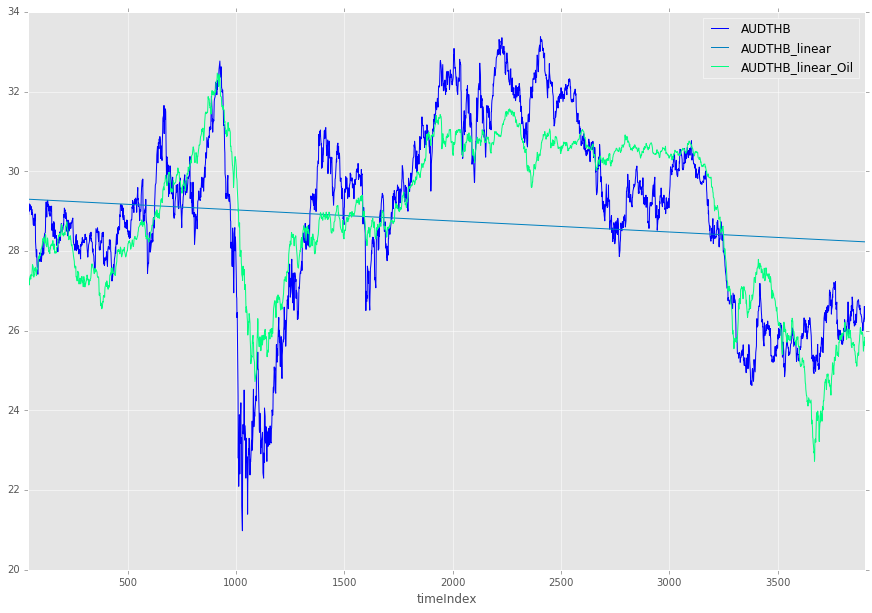

In [118]:
# see what the AUDTHB, Linear (AUDTHB only) and Linear Oil Price  plots by looks like, side by side
data5.plot(kind="line", colormap='winter', x="timeIndex", 
           y = ["AUDTHB", "AUDTHB_linear", "AUDTHB_linear_Oil"])

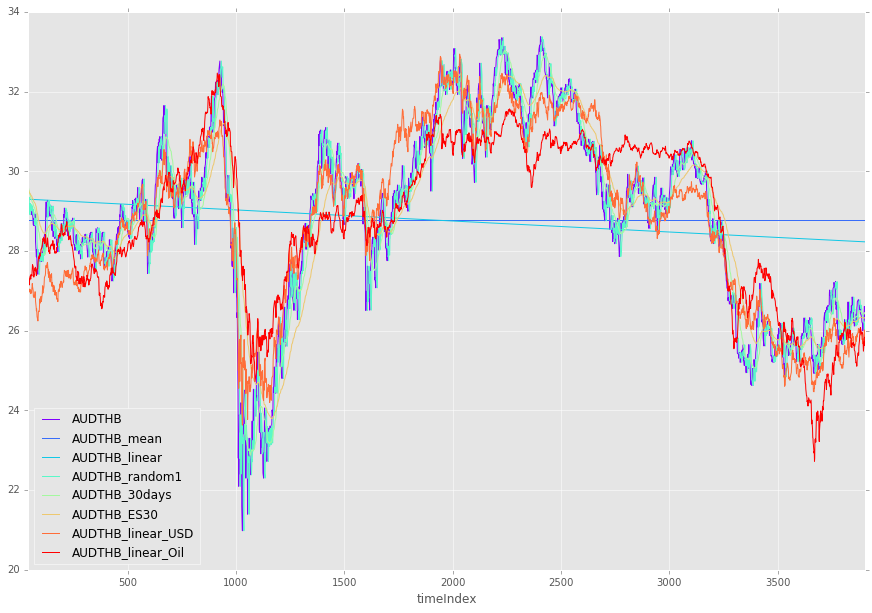

In [119]:
# plot everything
data5.plot(kind="line", colormap='rainbow', x="timeIndex", 
           y = ["AUDTHB", "AUDTHB_mean", "AUDTHB_linear", "AUDTHB_random1", "AUDTHB_30days", "AUDTHB_ES30", 
                "AUDTHB_linear_USD", "AUDTHB_linear_Oil"])

In [120]:
# Capture some new RMSE comparison metrics
model_linearOil_RMSE = RMSE(data5.AUDTHB_linear_Oil, data5.AUDTHB)
model_linearOil_RMSE

1.2654231680867729

In [121]:
# add to the comparison table
modResults.loc[6,"Model"] = "Linear_Oil"
modResults.loc[6,"Forecast"] = data5.AUDTHB_linear_Oil.iloc[-1]
modResults.loc[6,"RMSE"] = model_linearOil_RMSE
modResults.head(10)

,Model,Forecast,RMSE
0,Mean,28.7638,2.33621
1,Linear,28.5326,2.31842
2,Random,26.225,0.484842
3,MovAvg30,26.4486,0.6401
4,ExpSmoothing30,26.3243,0.939045
5,Linear_USD,25.7282,0.799497
6,Linear_Oil,25.8311,1.26542


In [122]:
# The RMSE has degraded...
# Oil_Price is not as strong a fit as AUDUSD trend

# 8. What if I add both AUDUSD and Oil Price as regressor features?

In [123]:
## Run the regression model to include 2 feature regressors - AUDUSD and Oil Price
# hold my breathe and model !
model_linear_USD_Oil = smf.ols('AUDTHB_log ~ timeIndex + np.log(AUDUSD) + np.log(Oil_Price)', data = data5).fit()

In [124]:
# what does the model look like?
model_linear_USD_Oil.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             AUDTHB_log   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     6669.
Date:                Wed, 28 Sep 2016   Prob (F-statistic):               0.00
Time:                        18:23:33   Log-Likelihood:                 5808.5
No. Observations:                2732   AIC:                        -1.161e+04
Df Residuals:                    2728   BIC:                        -1.159e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.4909      0.016    217.221      0.000       3.459       3.522
timeIndex         -1.572e-05    5.3e-07    -29.632      0.000   -1.68e-05   -1.47e-05
np.log(AUDUSD)        0.5844      0.009     64.526      0.000       0.567       0.602
np.log(Oil_Price)    -0.0044      0.003     -1.315      0.189      -0.011       0.002
==============================================================================
Omnibus:                       84.763   Durbin-Watson:                   0.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.105
Skew:                          -0.437   Prob(JB):                     9.99e-21
Kurtosis:                       3.214   Cond. No.                     7.56e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [125]:
## What if I multiply AUDUSD and Oil_Price?
# hold my breathe and model !
model_linear_USD_Oil2 = smf.ols('AUDTHB_log ~ timeIndex * np.log(AUDUSD) * np.log(Oil_Price)', data = data5).fit()

In [126]:
# what does the model look like?
model_linear_USD_Oil2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             AUDTHB_log   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     3682.
Date:                Wed, 28 Sep 2016   Prob (F-statistic):               0.00
Time:                        18:23:43   Log-Likelihood:                 6119.1
No. Observations:                2732   AIC:                        -1.222e+04
Df Residuals:                    2724   BIC:                        -1.217e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      3.7508      0.042     89.153      0.000       3.668       3.833
timeIndex                                     -0.0002   2.17e-05     -8.871      0.000      -0.000      -0.000
np.log(AUDUSD)                                 3.4408      0.135     25.473      0.000       3.176       3.706
timeIndex:np.log(AUDUSD)                      -0.0013   6.62e-05    -19.947      0.000      -0.001      -0.001
np.log(Oil_Price)                             -0.0681      0.009     -7.383      0.000      -0.086      -0.050
timeIndex:np.log(Oil_Price)                 4.147e-05   4.71e-06      8.799      0.000    3.22e-05    5.07e-05
np.log(AUDUSD):np.log(Oil_Price)              -0.7068      0.032    -22.403      0.000      -0.769      -0.645
timeIndex:np.log(AUDUSD):np.log(Oil_Price)     0.0003   1.48e-05     21.731      0.000       0.000       0.000
==============================================================================
Omnibus:                      163.856   Durbin-Watson:                   0.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              261.445
Skew:                          -0.484   Prob(JB):                     1.69e-57
Kurtosis:                       4.165   Cond. No.                     2.88e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.88e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [127]:
# R2 value has improved - there is a multiplicative effect of AUDUSD and Oil Price on AUDTHB !

In [128]:
# create a new var
data5["AUDTHB_linear_USD_Oil"] = np.exp(model_linear_USD_Oil.predict())

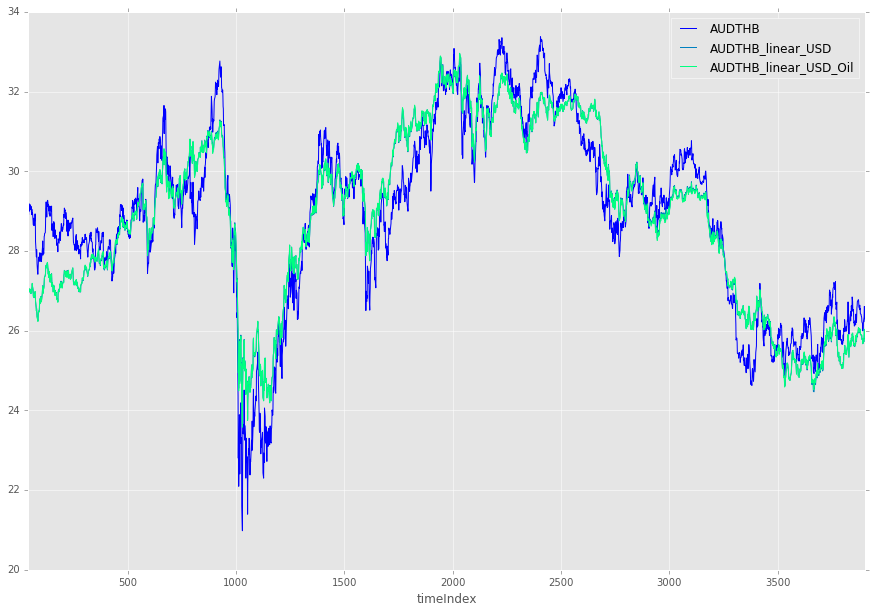

In [129]:
# see what the basket of AUDTHB, Linear (AUDTHB+AUDUSD) and now plus Oil Price plots by looks like
data5.plot(kind="line", colormap='winter', x="timeIndex", 
           y = ["AUDTHB", "AUDTHB_linear_USD" , "AUDTHB_linear_USD_Oil"])

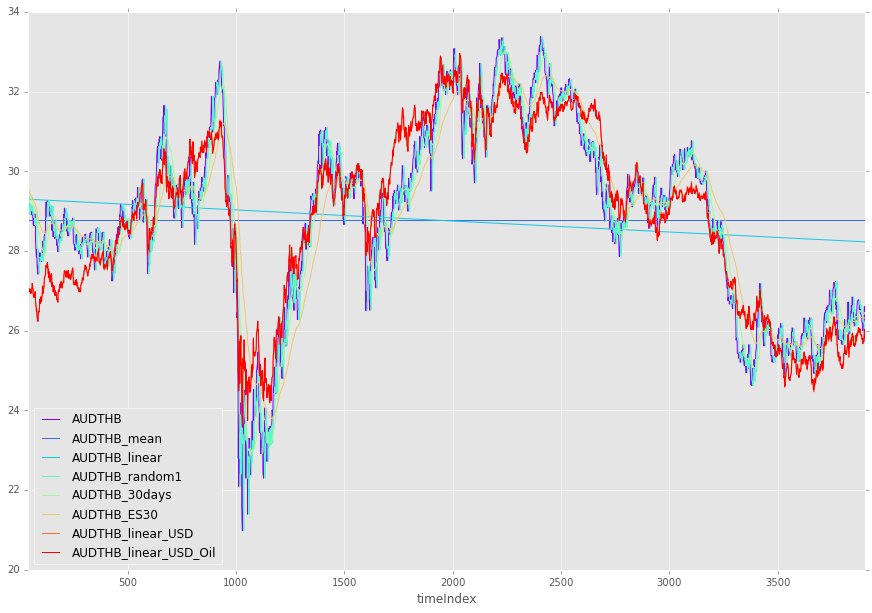

In [130]:
# include this the full basket
data5.plot(kind="line", colormap='rainbow', x="timeIndex", 
           y = ["AUDTHB", "AUDTHB_mean", "AUDTHB_linear", "AUDTHB_random1", "AUDTHB_30days", "AUDTHB_ES30", 
                "AUDTHB_linear_USD", "AUDTHB_linear_USD_Oil"])

In [131]:
# now to capture some RMSE comparison metrics
model_linearUSD_Oil_RMSE = RMSE(data5.AUDTHB_linear_USD_Oil, data5.AUDTHB)
model_linearUSD_Oil_RMSE

0.80096485320800193

In [132]:
# add to the comparison table
modResults.loc[7,"Model"] = "Linear_USD_Oil"
modResults.loc[7,"Forecast"] = data5.AUDTHB_linear_USD_Oil.iloc[-1]
modResults.loc[7,"RMSE"] = model_linearUSD_Oil_RMSE
modResults.head(10)

,Model,Forecast,RMSE
0,Mean,28.7638,2.33621
1,Linear,28.5326,2.31842
2,Random,26.225,0.484842
3,MovAvg30,26.4486,0.6401
4,ExpSmoothing30,26.3243,0.939045
5,Linear_USD,25.7282,0.799497
6,Linear_Oil,25.8311,1.26542
7,Linear_USD_Oil,25.7357,0.800965


In [133]:
# Interesting.. the model fit has vastly improved from using Oil only as a feature.
# Goes to say that the effect of AUDUSD on AUDTHB price is very strong and over-riding?